# Handle multi-omics Data with msmu


In [1]:
import matplotlib.pyplot as plt
import msmu as mm
import mofax as mofa
import muon as mu
import pandas as pd
import requests
import scanpy as sc
import seaborn as sns

plt.rcParams["font.family"] = "Arial"

random_state = 42

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail
/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


## Merge modalities


In [2]:
adata = sc.read_h5ad("GSE201575.h5ad")
mdata = mm.read_h5mu("MSV000089280.h5mu")
mdata.mod["rna"] = adata
mdata.update()
mdata

MuData object with n_obs × n_vars = 70 × 109376
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  4 modalities
    psm:	70 x 74025
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'cell'
      uns:	'acquisition', 'decoy', 'decoy_filter', 'filter', 'identification_file', 'label', 'level', 'quantification', 'quantification_file', 'search_engine'
      varm:	'filter', 'search_result'
      layers:	'raw'
    peptide:	70 x 18846
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'decoy', 'decoy_filter', 'filter', 'level'
      varm:	'filter'
    protein:	70 x 3054
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'decoy', 'decoy_filter', 'filter', 'level'
      varm:	'filter'
      layers:	'imputed'
    rna:	70 x 13451
      obs:	'filename', 'set', 'sample_id', 'sample', 'cell', 'condition', 'sample_rna', 'n_genes'
      var:	'n_cells'
      uns:	'log1p'
      layers:	'counts'

In [3]:
mdata.write_h5mu("multimodal.h5mu")

## WNN UMAP


In [4]:
mdata = mm.read_h5mu("multimodal.h5mu")
mdata_subset = mu.MuData({"protein": mdata.mod["protein"].copy(), "rna": mdata.mod["rna"].copy()})
mdata_subset.mod["protein"].X = mdata_subset.mod["protein"].layers["imputed"]

sc.pp.pca(mdata_subset.mod["rna"])
sc.pp.pca(mdata_subset.mod["protein"])
sc.pp.neighbors(mdata_subset.mod["rna"], n_pcs=4)
sc.pp.neighbors(mdata_subset.mod["protein"], n_pcs=4)

# Calculate weighted nearest neighbors (WNN)
mu.pp.neighbors(mdata_subset, key_added="wnn")
mu.tl.umap(mdata_subset, neighbors_key="wnn", random_state=random_state)

mdata.obsm["WNN_UMAP"] = mdata_subset.obsm["X_umap"]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(


### Fig 2B


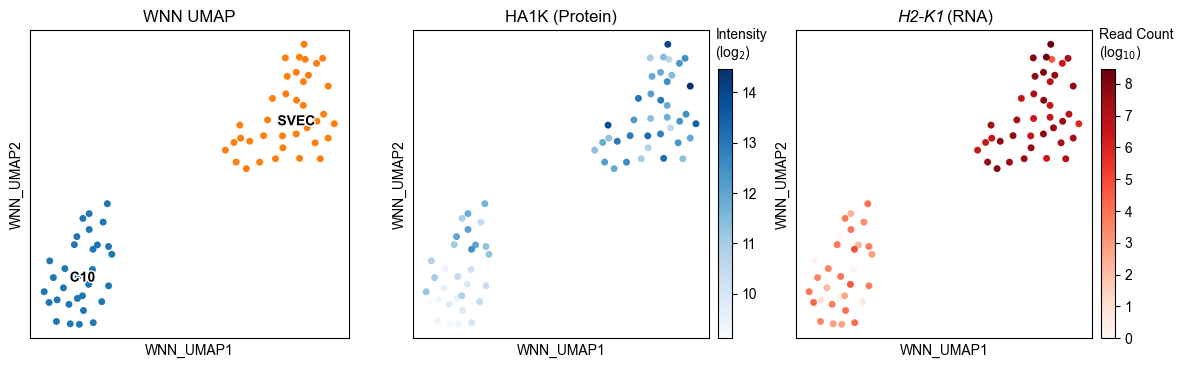

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))
mu.pl.embedding(
    mdata,
    basis="WNN_UMAP",
    color="cell",
    size=100,
    title="WNN UMAP",
    ax=ax0,
    legend_loc="on data",
    legend_fontoutline=2,
    show=False,
)
mu.pl.embedding(
    mdata,
    basis="WNN_UMAP",
    color="P04223",
    size=100,
    ax=ax1,
    title="HA1K (Protein)",
    colorbar_loc=None,
    show=False,
    cmap="Blues",
)
mu.pl.embedding(
    mdata,
    basis="WNN_UMAP",
    color="H2-K1",
    size=100,
    ax=ax2,
    title="",
    colorbar_loc=None,
    show=False,
    cmap="Reds",
)


fig.colorbar(mappable=ax1.collections[0], ax=ax1, fraction=0.05, aspect=20, pad=0.02, shrink=0.875, anchor=(1, 0))
fig.colorbar(mappable=ax2.collections[0], ax=ax2, fraction=0.05, aspect=20, pad=0.02, shrink=0.875, anchor=(1, 0))

ax1.collections[0].colorbar.set_label(
    "Intensity\n(log$_2$)",
    rotation=0,
    ha="left",
    va="bottom",
    x=0,
    y=1.025,
    labelpad=-30,
)
ax2.collections[0].colorbar.set_label(
    "Read Count\n(log$_{10}$)",
    rotation=0,
    ha="left",
    va="bottom",
    x=0,
    y=1.025,
    labelpad=-24,
)
ax2.text(0.5, 1.0175, "H2-K1", ha="right", va="bottom", transform=ax2.transAxes, fontstyle="italic", size=12)
ax2.text(0.51, 1.0175, "(RNA)", ha="left", va="bottom", transform=ax2.transAxes, size=12)

fig.savefig("Fig2B_WNN_UMAP.svg", dpi=300, bbox_inches="tight")

## MOFA


In [6]:
mdata = mm.read_h5mu("multimodal.h5mu")
mdata_subset = mu.MuData({"protein": mdata.mod["protein"].copy(), "rna": mdata.mod["rna"].copy()})

mdata_subset

MuData object with n_obs × n_vars = 70 × 16505
  2 modalities
    protein:	70 x 3054
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'decoy', 'decoy_filter', 'filter', 'level'
      varm:	'filter'
      layers:	'imputed'
    rna:	70 x 13451
      obs:	'filename', 'set', 'sample_id', 'sample', 'cell', 'condition', 'sample_rna', 'n_genes'
      var:	'n_cells'
      uns:	'log1p'
      layers:	'counts'

### Creating Model


In [7]:
mu.tl.mofa(mdata_subset, outfile="multimodal_model.hdf5", seed=random_state)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded view='protein' group='group1' with N=70 samples and D=3054 features...
Loaded view='rna' group='group1' with N=70 samples and D=13451 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (protein): gaussian
- View 1 (rna): gaussian




######################################
## Training the model with seed 42 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in multimodal_model.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


### Model Inspection


In [8]:
model = mofa.mofa_model("multimodal_model.hdf5")
model

MOFA+ model: multimodal model
Samples (cells): 70
Features: 16505
Groups: group1 (70)
Views: protein (3054), rna (13451)
Factors: 10
Expectations: W, Z

### Fig 2C


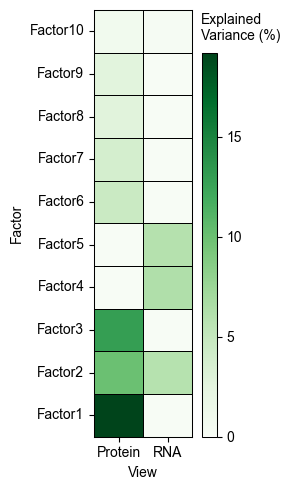

In [9]:
r2 = model.get_variance_explained(views=["protein", "rna"])

r2["View"] = r2["View"].map({"protein": "Protein", "rna": "RNA"})
r2["Factor"] = pd.Categorical(
    r2["Factor"],
    categories=[f"Factor{i+1}" for i in range(r2["Factor"].nunique())],
    ordered=True,
)
r2_mat = r2.pivot_table(index="Factor", columns="View", values="R2")

# Plot
fig = plt.figure(figsize=(3, 5))
ax = sns.heatmap(
    r2_mat,
    cmap="Greens",
    linecolor="black",
    linewidth=0.5,
    fmt=".2f",
    cbar_kws=dict(shrink=0.9, anchor=(1, 0), aspect=25, pad=0.05, fraction=0.15),
)

ax.collections[0].colorbar.set_label(
    "Explained\nVariance (%)",
    rotation=0,
    ha="left",
    va="bottom",
    x=0,
    y=1.025,
    labelpad=-30,
)
ax.invert_yaxis()

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(0.75)
    spine.set_visible(True)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 5, 10, 15])

for spine in cbar.ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(0.75)

fig.tight_layout()
fig.show()

fig.savefig("Fig2C_MOFA_R2.svg", bbox_inches="tight")

### Fig 2D


In [10]:
def fetch_protein_name(accession):
    url = f"https://rest.uniprot.org/uniprotkb/{accession}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    name = data.get("uniProtkbId", None)

    return name.split("_")[0]

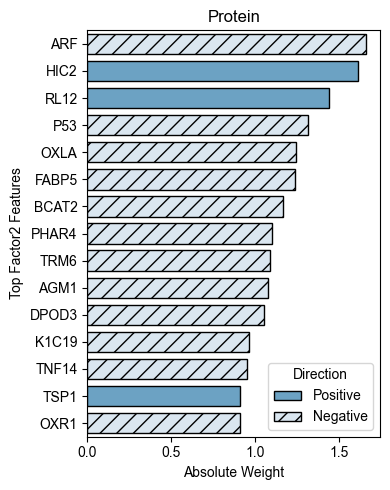

In [11]:
df_f2 = model.get_weights(
    views="protein",
    factors=1,
    df=True,
)
df_f2 = pd.melt(
    df_f2.reset_index().rename(columns={"index": "feature"}),
    id_vars="feature",
    var_name="factor",
    value_name="value",
)
df_f2["abs_value"] = abs(df_f2.value)
df_f2["sign"] = df_f2["value"].apply(lambda x: "Positive" if x >= 0 else "Negative")
df_f2["sign"] = pd.Categorical(df_f2["sign"], categories=["Positive", "Negative"], ordered=True)

# Assign ranks to features, per factor
df_f2["abs_rank"] = df_f2.groupby("factor")["abs_value"].rank(ascending=False)
df_f2 = df_f2.sort_values(["factor", "abs_rank"], ascending=True)
df_f2 = df_f2[df_f2["abs_rank"] <= 15]
df_f2["gene"] = df_f2["feature"].apply(lambda x: fetch_protein_name(x))

fig = plt.figure(figsize=(4, 5))
ax = sns.barplot(
    data=df_f2,
    x="abs_value",
    y="gene",
    hue="sign",
    dodge=False,
    palette={"Positive": "#5DA5D1", "Negative": "#D6E6F4"},
    width=0.75,
    edgecolor="black",
)

for container, hatch in zip(ax.containers, ["", "//"]):
    for bar in container:
        bar.set_hatch(hatch)

ax.set_title("Protein")
ax.xaxis.set_ticks([0, 0.5, 1.0, 1.5])
ax.set_xlabel("Absolute Weight")
ax.set_ylabel("Top Factor2 Features")
ax.legend(title="Direction")

fig.tight_layout()
fig.savefig("Fig2D_f2_prot.svg", bbox_inches="tight")

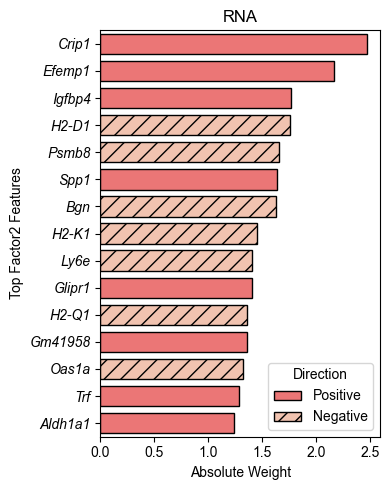

In [12]:
df_f2 = model.get_weights(
    views="rna",
    factors=1,
    df=True,
)
df_f2 = pd.melt(
    df_f2.reset_index().rename(columns={"index": "feature"}),
    id_vars="feature",
    var_name="factor",
    value_name="value",
)
df_f2["abs_value"] = abs(df_f2.value)
df_f2["sign"] = df_f2["value"].apply(lambda x: "Positive" if x >= 0 else "Negative")
df_f2["sign"] = pd.Categorical(df_f2["sign"], categories=["Positive", "Negative"], ordered=True)

# Assign ranks to features, per factor
df_f2["abs_rank"] = df_f2.groupby("factor")["abs_value"].rank(ascending=False)
df_f2 = df_f2.sort_values(["factor", "abs_rank"], ascending=True)
df_f2 = df_f2[df_f2["abs_rank"] <= 15]

fig = plt.figure(figsize=(4, 5))
ax = sns.barplot(
    data=df_f2,
    x="abs_value",
    y="feature",
    hue="sign",
    dodge=False,
    palette={"Positive": "#FF6262", "Negative": "#FCBEA5"},
    width=0.75,
    edgecolor="black",
)

for container, hatch in zip(ax.containers, ["", "//"]):
    for bar in container:
        bar.set_hatch(hatch)

ax.set_title("RNA")
ax.xaxis.set_ticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
ax.set_xlabel("Absolute Weight")
ax.set_ylabel("Top Factor2 Features")
for tick in ax.get_yticklabels():
    tick.set_fontstyle("italic")
ax.legend(title="Direction")

fig.tight_layout()
fig.savefig("Fig2D_f2_rna.svg", bbox_inches="tight")